In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

In [38]:
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBClassifier, plot_importance
import xgboost as xgb

# Wczytanie danych

In [5]:
DATA_PATH = "Datasets/HCMST 2017 fresh sample for public sharing draft v1.1.dta"

In [6]:
df = pd.read_stata(DATA_PATH)

In [7]:
target = ["S1"]
cat_feat = ['hcm2017q24_internet_other', 'PPT01']
float_feat = ['Q16', 'age_when_met']
feat = cat_feat + float_feat + target

In [70]:
relevant_features = cat_feat + float_feat
relevant_features = np.array(relevant_features)

# Preprocessing

In [8]:
df = df[feat]
df = df.dropna()
df[cat_feat] = df[cat_feat].apply(lambda x: x.cat.codes, axis=0)
df[target] = (df[target] == "Yes, I am Married").astype(int)

In [9]:
df_X = df[feat[:-1]]
df_y = df[target]

In [10]:
X = df_X.values
y = df_y.values

In [65]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Champion

In [39]:
fix_params = {'objective': 'binary:logistic', "seed": 42, }
param_dist = {
    'n_estimators': stats.randint(150, 500),
    'learning_rate': np.linspace(0.01,0.1, 10),
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)],
    'max_depth': [3, 4, 5, 6, 7, 8, 9],
    'colsample_bytree': stats.uniform(0.5, 0.45),
    'min_child_weight':[1, 2, 4, 6, 8, 10, 12],
    'gamma':[i/10.0 for i in range(0,5)]
             }
clf = RandomizedSearchCV(estimator=XGBClassifier(**fix_params), param_distributions = param_dist, n_iter = 25, scoring = 'auc', cv=5, n_jobs = -1)
clf.fit(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [40]:
best_params = {**clf.best_params_, **fix_params}
bb_clf_xgb = XGBClassifier(**best_params)
bb_clf_xgb.fit(x_train, y_train)

In [59]:
y_prob_xgb = bb_clf_xgb.predict_proba(x_test)[:,1]
roc_auc_score(y_test, y_prob_xgb)

0.6722551602986385

## Challenger

In [51]:
from sklearn.tree import DecisionTreeClassifier

In [52]:
bb_clf_lr = LinearRegression()
bb_clf_lr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [60]:
y_prob_lr = bb_clf_lr.predict(x_test)
roc_auc_score(y_test, y_prob_lr)

0.6603645147123408

# Permutation Importance

In [86]:

def perm(clf, x_test, y_test, is_lr=False, k=10):
    importances = []
    for j in range(X.shape[1]):
        score = 0
        x_t = x_test.copy()
        for _ in range(k):
            x_t[:, j] = np.random.permutation(x_t[:, j])
            y_pred = clf.predict(x_t) if is_lr else clf.predict_proba(x_t)[:,1]
            score += 1 - roc_auc_score(y_test, y_pred)
        importances.append((j, score/k))
    
    return np.array(importances)


def plot_importance_raw(chart, features):
    chart = chart[chart[:,1].argsort()]
    idx, importance = chart[:,0], chart[:,1]
    plt.bar(features[idx.astype(int)], importance)

    
def display_perm_importance(clf, x_test, y_test, features, is_lr=False):
    chart = perm(clf, x_test, y_test, is_lr)
    plt.figure(figsize=(10,10))
    plot_importance_raw(chart, features)

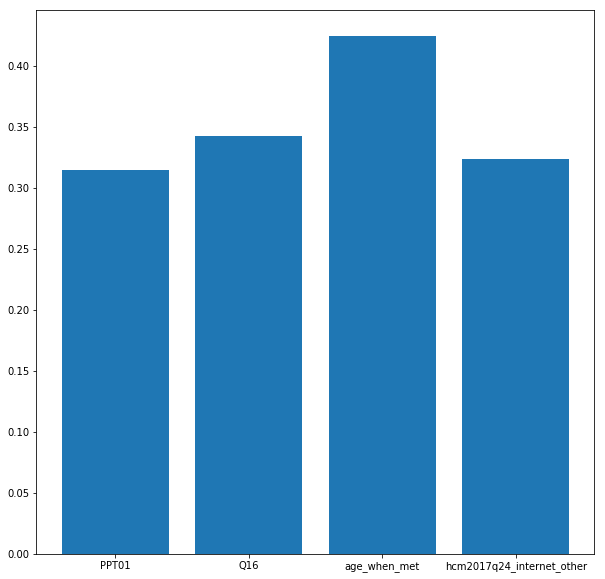

In [87]:
display_perm_importance(bb_clf_xgb, x_test, y_test, relevant_features, is_lr=False)

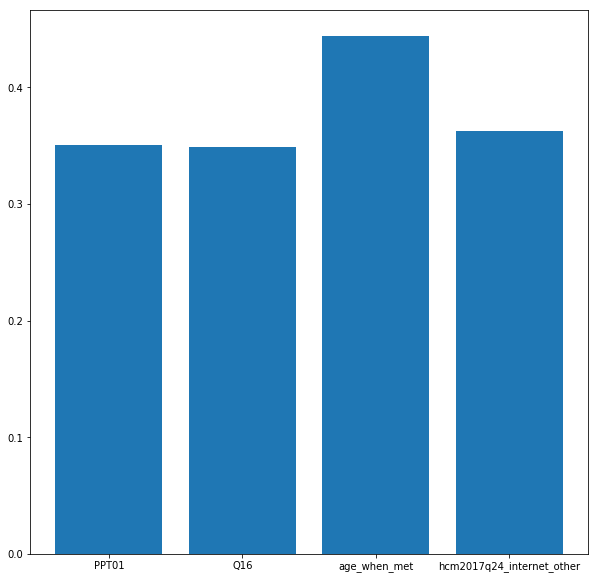

In [88]:
display_perm_importance(bb_clf_lr, x_test, y_test, relevant_features, is_lr=True)

# ALE- Plot

In [92]:
def ale_plot(model, S, df, k=50, is_lr=False):
    estimator = []
    points = np.linspace(df[S].min(), df[S].max(), 20)
    df_c = df.copy()
    bound = df_c[S].quantile(np.linspace(0, 1, k+1)).values
    df_c["which_interval"] = df_c[S].apply(lambda x: (x <= bound[1:]).argmax())
    df_c_grouped = df_c.groupby(by="which_interval")
    for x in points:
        est = 0
        for i, sub_df in df_c_grouped:
            sub_df = sub_df.drop(columns=["which_interval"])
            df_c1 = sub_df.copy()
            df_c2 = sub_df.copy()
            df_c1[S] = bound[i]
            df_c2[S] = bound[i+1]
            res = model.predict(df_c2.values) - model.predict(df_c1.values) if is_lr else model.predict_proba(df_c2.values)[:,1] - model.predict_proba(df_c1.values)[:,1]
            res = res.sum() / sub_df.shape[0]
            est += res
            if bound[i+1] >= x:
                break
                
        estimator.append((x, est))
    
    estimator = np.array(estimator)
    estimator[:, 1] -= estimator[:,1].mean()
    plt.grid(linewidth=0.25)
    plt.xlabel("feature: {}".format(S))
    plt.ylabel("marriage probability centralized")
    plt.plot(estimator[:, 0], estimator[:, 1])
    
        

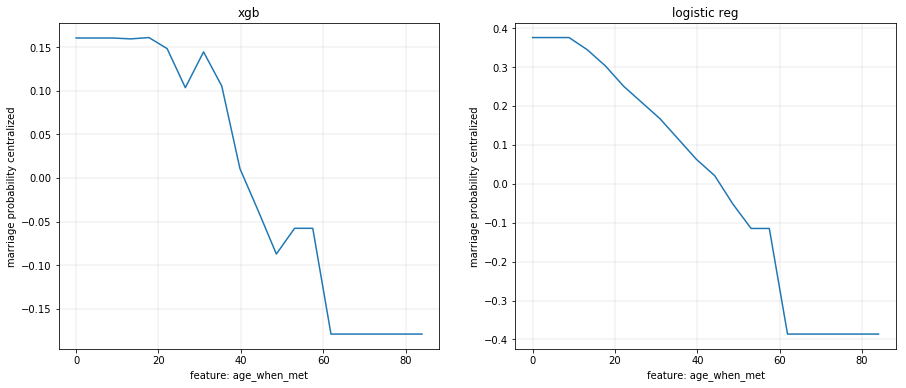

In [96]:

K = 50
fig = plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.title("xgb")
ale_plot(bb_clf_xgb, S=float_feat[1], df=df_X, k=K, is_lr=False)

plt.subplot(1, 2, 2)
plt.title("logistic reg")
ale_plot(bb_clf_lr, S=float_feat[1], df=df_X, k=K, is_lr=True)

plt.show()

# Wnioski

Modele nie różnily się od siebie zbytnio, więc nawet cecha najbardziej je rozróżniająca, nie ukazuje za dużo różnic. Widzimy jedynie, iż estymator regresyjny, posiada gładszy przebieg